In [1]:
import torch
from torch.utils.data import IterableDataset
from torchtext.data import TabularDataset
from torch.utils.data import DataLoader
from torchtext import data

# Traemos los datos de mongo

In [2]:
import pymongo

myclient = pymongo.MongoClient("mongodb://localhost:27017/")

dbname = "aboriton"

db = myclient[dbname]

In [3]:
base_query = {}
rt_query = {**base_query, **{"tweet.retweeted_status": {"$exists": True}}}


tweets = db.abortion.find(base_query)
rts = db.abortion.find(rt_query)


print("Tenemos {:.2f}M tweets ({:.2f}M RTs)".format(tweets.count() / 1e6, db.abortion.count_documents(rt_query) / 1e6))

/home/damifur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  if __name__ == '__main__':


Tenemos 0.61M tweets (0.46M RTs)


In [4]:
cantidad_de_usuarios = len(db.abortion.find(rt_query).distinct('user'))

print("Cantidad de retwitteros : {}".format(cantidad_de_usuarios))

Cantidad de retwitteros : 219183


# Grafo de Retweets

In [5]:
import networkx as nx

full_g = nx.Graph()
vertex_ids = set()


for retweet in rts:
    original_tweet = retweet["tweet"]["retweeted_status"]
    full_g.add_edge(retweet["user"], original_tweet["user"]["id"])

In [6]:
n = len(full_g.nodes)
m = len(full_g.edges)
complete = n * (n-1) / 2

print("Nodos: {:.2f}M".format((n / 1e6)))
print("Ejes: {:.2f}M".format((m / 1e6)))

Nodos: 0.23M
Ejes: 0.40M


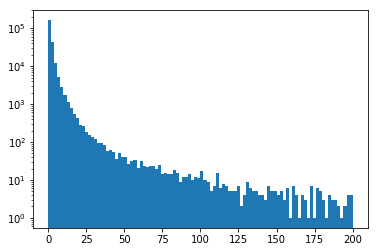

In [7]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

degrees = np.array([full_g.degree(node) for node in full_g.nodes()])

plt.hist(degrees, range=(0, 200), bins=100);
plt.semilogy();

In [8]:
def subgraph_strong_nodes(g, n):
    """
    Devuelve subgrafo con nodos de grado mayor a n
    """
    good_nodes = [node for node in g.nodes() if g.degree(node) >= n]
    
    return g.subgraph(good_nodes)

g = subgraph_strong_nodes(full_g, 5)

print("Nos quedan {:.2f}M nodos (antes eran {:.2f}M)".format(
    len(g.nodes) / 1e6,
    len(full_g.nodes) / 1e6
))
print("Componentes conexas = {}".format(len(list(nx.connected_components(g)))))

Nos quedan 0.02M nodos (antes eran 0.23M)
Componentes conexas = 875


In [9]:
components = list(nx.connected_components(g))

print("Componentes conexas = {}".format(len(components)))

print("Componente 0  --> {:<6} usuarios".format(len(components[0])))

resto = [len(components[i]) for i in range(1, len(components))]
print("Restantes     --> {:<6} usuarios".format(sum(resto)))

Componentes conexas = 875
Componente 0  --> 19000  usuarios
Restantes     --> 923    usuarios


In [10]:
# Take the biggest component. Usually it's the first but not necessarily
g = g.subgraph(components[0])

# Corremos Louvain para encontrar las comunidades

In [11]:
partitions = {}

In [12]:
import cylouvain
import time
from collections import Counter

user_threshold = 100

for resolution in  [1, 1.5, 2, 3, 5, 6, 7, 10, 15]:
    begin = time.time()
    print("resolución {:.2f}".format(resolution), end="")
    
    partition = cylouvain.best_partition(g, resolution=resolution)
    end = time.time()
    
    num_partitions = len(set(partition.values()))
    counter = Counter(partition.values())
    
    
    important_partitions = len([_ for x in counter.items() if x[1] > user_threshold])
    
    print("---> {} particiones ({} con más de {} usuarios)".format(
        num_partitions,
        important_partitions,
        user_threshold,
    ))
    #print("Tiempo: {:.2f} minutos".format((end - begin) / 60))
    partitions[resolution] = partition

resolución 1.00---> 28 particiones (10 con más de 100 usuarios)
resolución 1.50---> 19 particiones (8 con más de 100 usuarios)
resolución 2.00---> 11 particiones (7 con más de 100 usuarios)
resolución 3.00---> 10 particiones (5 con más de 100 usuarios)
resolución 5.00---> 6 particiones (4 con más de 100 usuarios)
resolución 6.00---> 6 particiones (4 con más de 100 usuarios)
resolución 7.00---> 6 particiones (4 con más de 100 usuarios)
resolución 10.00---> 5 particiones (3 con más de 100 usuarios)
resolución 15.00---> 4 particiones (3 con más de 100 usuarios)


In [13]:
modularity = 10.0
partition = partitions[modularity]
partition_to_ids = {partition_number:[] for partition_number in range(len(set(partition.values())))}

num_partitions = len(set(partition.values()))
for user_id, user_partition in partition.items():
    partition_to_ids[user_partition].append(user_id)

In [14]:
cache_users = {}
def get_user(user_id):
    if user_id not in cache_users:
        user = db.users.find_one({"id": user_id})
        if user:
            cache_users[user_id] = user
        else:
            cache_users[user_id] = None
    return cache_users[user_id] 
    

In [15]:
import nltk
from tweepy import TweepError
from collections import Counter

users_with_tweets = db.abortion.find({
    **base_query
}).distinct('user')
    

    
def most_followed_by(followers, N=5):
    """
    Returns the ids of the users most retweeted by followers
    
    Arguments:
    ---------
    
    followers: iterable of dicts/user documents
        The dicts should have the key 'friends_ids' 
        
    N: int (default=5)
        Number of top-followed users to return

    
    """
    fd = nltk.FreqDist()
    
    for follower in followers:
        try:
            for fid in follower["friends_ids"]:
                fd[fid] += 1
        except KeyError as e:
            """ No tiene friends_ids """
            continue
        
    return fd.most_common(N)

def most_retweeted(users, N=5):
    user_ids = [u["id"] for u in users]
    
    retweets = db.abortion.find({
        **rt_query,
        **{
            "user": {"$in": user_ids},
        }
    })
    
    counter = Counter(tweet["tweet"]["retweeted_status"]["user"]["id"] for tweet in retweets)
    
    return counter.most_common(N)
    
    

def users_of_community(db, partition_number, has_tweets=True):    
    user_ids = partition_to_ids[partition_number]
    
    if has_tweets:
        user_ids = set(user_ids).intersection(users_with_tweets)
    return db.users.find({
        "id": {"$in": list(user_ids)}
    })


def community_info(partition_number, 
                   num_users=5, num_tweets=5, followers=10,
                   user_threshold=10):
    users = list(users_of_community(db, partition_number))
    
    if len(users) <= user_threshold:
        return
    
    print(("*" * 40 + '\n') * 4)
    print("Partición {}".format(partition_number))
    print("Cantidad de usuarios: {}".format(len(users)))

    
    user_ids = [user["id"] for user in users]
    num_tweets = db.abortion.count_documents({
        **base_query,
        **{"user": {"$in": user_ids}}
    })
    print("Cantidad de tweets: {}".format(num_tweets))
    
    """
    print("\n\nUsuarios más seguidos\n\n")
    for i, (user_id, count) in enumerate(most_followed_by(users, followers)):
        try:
            user = get_user(user_id)
            print("{0:<2}. {2:<35} (@{1:<20}) -- {3:<6} seguidores".format(i+1, user["screen_name"], user["name"], count))
        except TweepError as e:
            print("{} - {}".format(user_id, e))
    """
    print("\n\nUsuarios más RT \n\n")
    for i, (user_id, count) in enumerate(most_retweeted(users, followers)):
        try:
            user = get_user(user_id)
            if user:
                print("{0:<2}. {2:<22} (@{1:<15}) -- {3:<6} RT".format(
                    i+1, 
                    user["screen_name"][:20], 
                    user["name"][:15], 
                    count))
        except TweepError as e:
            print("{} - {}".format(user_id, e))
    
    
    for user in users[:num_users]:
        print((('=')*50 + '\n')*3)

        print("{1} (@{0})".format(user['screen_name'], user['name']))
        print("Ubicación: ", user['location'])
        print("Descripción: ", user['description'])
        print(user['id'])
        
        query = {
            **base_query,
            **{
                "tweet.user.id": user["id"], 
            }
        }
        
        tweets = db.abortion.find(query).limit(num_tweets)
        
        print("\nTweets:")
        
        for tweet in tweets:
            if 'tweet' in tweet and 'full_text' in tweet['tweet']:
                print(tweet['tweet']['full_text'])

In [16]:
for i in range(num_partitions):
    community_info(i, num_users=10, followers=20, num_tweets=3, user_threshold=user_threshold)

****************************************
****************************************
****************************************
****************************************

Partición 1
Cantidad de usuarios: 13044
Cantidad de tweets: 165422


Usuarios más RT 


1 . LifeNews.com           (@LifeNewsHQ     ) -- 16326  RT
2 . Live Action            (@LiveAction     ) -- 4603   RT
3 . Charlie Kirk           (@charliekirk11  ) -- 3894   RT
4 . 🇺🇸👶✝️I am ProLi        (@Prolife_IAM    ) -- 3577   RT
5 . Abby Johnson           (@AbbyJohnson    ) -- 2144   RT
6 . Judicial Watch         (@JudicialWatch  ) -- 2039   RT
7 . March for Life         (@March_for_Life ) -- 2022   RT
8 . LAYLA {⭐}              (@LaylaAlisha11  ) -- 1991   RT
9 . Lila Rose              (@LilaGraceRose  ) -- 1990   RT
10. Fr. Frank Pavon        (@frfrankpavone  ) -- 1986   RT
11. Educating Liber        (@Education4Libs ) -- 1612   RT
12. Cori #Trump2020        (@Cocofritz      ) -- 1530   RT
13. Rod The Nationa        (@RodHillis1

After fighting an intense legal battle to keep out evidence , #PlannedParenthood's own attorney just opened the door to disturbing testimony in our trial . This is a big deal . We can defeat Planned Parenthood but we need you . Sign our petition today . https://t.co/XEzTRTb7UU
Join me right now in Mexico where I'm on stage to debate protecting innocent human life in the womb : https://t.co/b8cgMhfJHG #prolife
@The_War_Economy Here's his district . He's soft on border issues & abortion . There's no mystery he's IC . https://t.co/jgQAdMxPxY
@The_War_Economy Here's his district . He's soft on border issues & abortion . There's no mystery he's IC . https://t.co/jgQAdMxPxY
. @giannajessen to Congress : “ If abortion is merely about women ’ s rights , then where were mine ? ” Human rights begin in the womb . We must protect the rights of ALL women — born and unborn . #ProLife #ChooseLife 💓 👣 https://t.co/nyxmls9ACJ

Rhianna Rita Starr (@rhianna)
Ubicación:  New York, NY
Descripción:  Tarot c

Cantidad de tweets: 1061


Usuarios más RT 


1 . charity Mukuba         (@mukuba_charity ) -- 85     RT
2 . Wuod Japuonj           (@OsumbaJM       ) -- 57     RT
3 . Amos Kilanya           (@AmosKilanya    ) -- 42     RT
4 . Digital Native🇰        (@EmodiaBenjamin ) -- 41     RT
5 . Monica Nyaga.          (@nyagamoniq     ) -- 41     RT
6 . Lilian🇰🇪               (@PstLily        ) -- 40     RT
7 . Nelson Amenya          (@amenya_nelson  ) -- 37     RT
8 . Julius 🇰🇪              (@J_Kikwai       ) -- 28     RT
9 . Pizzahmwitu            (@pizzahmwitu    ) -- 19     RT
10. Kibet Vincent R        (@KibetVincentRo1) -- 18     RT
11. Susan Wanjiru          (@swanjirul      ) -- 15     RT
12. Catholic MPs Ke        (@CatholicmpsKE  ) -- 11     RT
13. Bshp Albert            (@BshpAlbert     ) -- 11     RT
14. Charity                (@charity_sang   ) -- 11     RT
15. Sir Ian                (@ianowilid      ) -- 10     RT
16. willie ngugi           (@williengugi3   ) -- 10     RT
17. Arthur

Kenya is a GOD fearing nation , why are we now propagating laws on abortion , homosexuality . Have we stopped fearing GOD ? I am a sad Kenyan today #LetterToTheState
Today I ask myself , what is of more value to this nation . Money or the sanctity of life ? Let us not destroy the future of Kenya with the ICPD Summit.Say no to abortion #LetterToTheState
The Bible is Clear , Murder is sin and those who practise it they have their place in the eternal Hell fire ! I am asking today , why then legalize abortion ? Aren't you aware the Bible warns against killing ? #LetterToTheState
I am not ashamed of the gospel , because it is the power of God for the salvation of everyone who believes : This gospel says NO TO SIN , , , Homosexuality is SinAbortion is Sin #LetterToTheState https://t.co/ptPx5btRrl
Dear Kenyans , This is our country , and we are a GOD fearing people.JESUS paid a very heavy price for our redemption and salvation.Abortion is murder , we cannot allow it . #LetterToTheStatehttps 

Cantidad de tweets: 49824


Usuarios más RT 


1 . NARAL                  (@NARAL          ) -- 1469   RT
2 . EMILY's List           (@emilyslist     ) -- 964    RT
3 . Senator Mazie H        (@maziehirono    ) -- 876    RT
4 . Lauren Rankin          (@laurenarankin  ) -- 760    RT
5 . Rewire.News            (@Rewire_News    ) -- 583    RT
6 . Janis Irwin            (@JanisIrwin     ) -- 470    RT
7 . Center for Repr        (@ReproRights    ) -- 412    RT
8 . Planned Parenth        (@PPact          ) -- 394    RT
9 . Planned Parenth        (@PPFA           ) -- 344    RT
10. UNFPA                  (@UNFPA          ) -- 280    RT
11. Nairobi Summit         (@NairobiSummit  ) -- 274    RT
12. The Unruly Squi        (@educatedadult1 ) -- 261    RT
13. Leah Torres, MD        (@LeahNTorres    ) -- 250    RT
14. prochoiceforall        (@prochoiceforal1) -- 236    RT
15. robin heide            (@robinandriver  ) -- 227    RT
16. John Pavlovitz         (@johnpavlovitz  ) -- 217    RT
17. Renee

There ’ s a reason Shelby County , which gutted voting rights was decided two years before Obergefell — and we heard minimal repulse from LGBTQ organizations . Similar reasons they are silent around abortion , contraception , sex work , among others . We ’ re asterisks .
This week , the U . S . Ambassador to the United Nations objected to the use of the phrase " sexual and reproductive health " because it could " suggest a right to abortion . " Make no mistake : They are coming for women's freedom on a global scale . https://t.co/1BFBnS2ppf
@gaywonk @alexkotch @ebruenig No thank you . Anti-abortion " leftists " need to gtfo .
I'm done with Democratic strategists worrying that supporting abortion rights will cause a candidate to lose . 73 % of Americans want Roe v . Wade to remain the law of the land . But more importantly , abortion is a fundamental right . We don't discard human rights to win elections .
Refusing to support abortion as a candidate only allows abortion stigma to flouri

What is it with these men ? Is it a fetish ? Missouri health director kept spreadsheet of Planned Parenthood patients ’ periods https://t.co/NeyBzTvbvW
Remember when Adriana Cohen on @RealClearNews said “ It's well-documented that many conservative leaders & activists have been unwelcome or outright banned from speaking at colleges and universities , including pro-life & conservative commentator Ben Shapiro . ” Are they ok w this 👇 https://t.co/VIc1NQJxCg
There ’ s literally a whole fucking party dedicated to anti-abortion hardlining , he can join that one , christ allflippingmighty , why would anyone even ask this https://t.co/Q9ArLUeWV9


# Armamos datasets con los tweets de cada comunidad

In [17]:
def tweets_of_community(partition_num):
    users = list(users_of_community(db, partition_num))
    user_ids = [user["id"] for user in users]
    tweets = [tweet['tweet']['full_text'] for tweet in db.abortion.find({**base_query,**{"user": {"$in": user_ids}}}, {"tweet.full_text": 1})]
    return tweets

In [17]:
# Favor y against are merely orientative names. At this point it's not important which stance takes the community, we are going to decide that later
# Nevertheless, I checked the community info and assigned each community to the name I though was a better fit, though we are going to validate this in the future
tweets_favor = tweets_of_community(3)
tweets_agains = tweets_of_community(1)

NameError: name 'tweets_of_community' is not defined

In [19]:
w_train = open("abortion_favor_dataset_train.tsv", 'w')
w_train.write("text\n")
for tweet in tweets_favor[:-200]:
    w_train.write("{}\n".format(tweet.replace('\n','').replace('\t','')))
w_train.close()

w_val = open("abortion_favor_dataset_val.tsv", 'w')
w_val.write("text\n")
for tweet in tweets_favor[-200:-100]:
    w_val.write("{}\n".format(tweet.replace('\n','').replace('\t','')))
w_val.close()

w_test = open("abortion_favor_dataset_test.tsv", 'w')
w_test.write("text\n")
for tweet in tweets_favor[-100:]:
    w_test.write("{}\n".format(tweet.replace('\n','').replace('\t','')))
w_test.close()

w_train_against = open("abortion_against_dataset_train.tsv", 'w')
w_train_against.write("text\n")
for tweet in tweets_agains[:-200]:
    w_train_against.write("{}\n".format(tweet.replace('\n','').replace('\t','')))
w_train_against.close()

w_val_against = open("abortion_against_dataset_val.tsv", 'w')
w_val_against.write("text\n")
for tweet in tweets_agains[-200:-100]:
    w_val_against.write("{}\n".format(tweet.replace('\n','').replace('\t','')))
w_val_against.close()

w_test_against = open("abortion_against_dataset_test.tsv", 'w')
w_test_against.write("text\n")
for tweet in tweets_agains[-100:]:
    w_test_against.write("{}\n".format(tweet.replace('\n','').replace('\t','')))
w_test_against.close()

w_all = open("abortion_complete_dataset.tsv", 'w')
w_all.write("text\n")
for tweet in tweets_agains:
    w_all.write("{}\n".format(tweet.replace('\n','').replace('\t','')))
for tweet in tweets_favor:
    w_all.write("{}\n".format(tweet.replace('\n','').replace('\t','')))
w_all.close()

In [2]:
TEXT = data.Field(
    tokenizer_language='en',
    lower=True,
    init_token='<sos>',
    eos_token='<eos>',
    batch_first=True,
)

In [3]:
train_favor, val_favor, test_favor = data.TabularDataset.splits(path="", train="abortion_favor_dataset_train.tsv", validation="abortion_favor_dataset_val.tsv", test="abortion_favor_dataset_test.tsv", format="tsv", fields=[('text', TEXT)])
train_against, val_against, test_against = data.TabularDataset.splits(path="", train="abortion_against_dataset_train.tsv", validation="abortion_against_dataset_val.tsv", test="abortion_against_dataset_test.tsv", format="tsv", fields=[('text', TEXT)])
train_all = data.TabularDataset(path="abortion_complete_dataset.tsv", format="tsv", fields=[("text", TEXT)])

In [4]:
TEXT.build_vocab(train_all, vectors="glove.6B.300d")
print(f"We have {len(TEXT.vocab)} tokens in our vocabulary")

We have 100087 tokens in our vocabulary


In [5]:
def dataset2example(dataset):
    examples = list(map(lambda example: ['_bos_']+ example.text + ['_eos_'], dataset.examples))
    examples = [item for example in examples for item in example]
    example = data.Example()
    setattr(example, 'text', examples)
    return data.Dataset([example], fields={'text': TEXT})

In [6]:
train_favor = dataset2example(train_favor)
val_favor = dataset2example(val_favor)
test_favor = dataset2example(test_favor)

In [7]:
train_against = dataset2example(train_against)
val_against = dataset2example(val_against)
test_against = dataset2example(test_against)

# Bert Classifier

### We get the neutral data from other datasets

In [1]:
import argparse
import glob
import logging
import os
import random

import numpy as np
import torch
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorboardX import SummaryWriter
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

from transformers import WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer
import pandas as pd

import transformers
import sklearn
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule_with_warmup

from io import open

import sys

from sklearn import metrics

import matplotlib.pyplot as plt

import string

random.seed(42)

I0128 12:10:18.849649 140620505528064 file_utils.py:35] PyTorch version 1.4.0 available.


In [2]:
def preprocess(tweet):
    printable = set(string.printable)
    ans = []
    for word in tweet.split(' '):
        if not word.startswith("@") and not word.startswith("http"):
            ans.append(''.join(list(filter(lambda x: x in printable, word))))
    return ' '.join(ans).replace('\n','').replace('\t','')

In [3]:
# w = open("feminism_community_based_classification.csv", 'w')
# w.write("text\tlabel\n")

# # favor_train_ds = open("abortion_favor_dataset_train.tsv", 'r')
# # favor_test_ds = open("abortion_favor_dataset_test.tsv", 'r')
# # favor_dev_ds = open("abortion_favor_dataset_val.tsv", 'r')
# # tweets_all_favor = set([preprocess(line) for line in favor_train_ds]).union([preprocess(line) for line in favor_test_ds]).union([preprocess(line) for line in favor_dev_ds])
# favor_ds = open("feminism_favor_dataset.tsv")
# tweets_all_favor = set([preprocess(line) for line in favor_ds])
# for tweet in tweets_all_favor:
#     if tweet.replace(' ','') != "":
#         w.write("{}\tFAVOR\n".format(tweet))climate-change_community_based_classification

# print(len(tweets_all_favor))

# # against_train_ds = open("abortion_against_dataset_train.tsv", 'r')
# # against_test_ds = open("abortion_against_dataset_test.tsv", 'r')
# # against_dev_ds = open("abortion_against_dataset_val.tsv", 'r')
# # tweets_all_against = set([preprocess(line) for line in against_train_ds]).union([preprocess(line) for line in against_test_ds]).union([preprocess(line) for line in against_dev_ds])
# against_ds = open("feminism_against_dataset.tsv", 'r')
# tweets_all_against = set([preprocess(line) for line in against_ds])
# for tweet in tweets_all_against:
#     if tweet.replace(' ','') != "":
#         w.write("{}\tAGAINST\n".format(tweet))

# print(len(tweets_all_against))
    
# abortion = open("abortion_unlabeled_sample_complete_without_preprocessing.csv", 'r')
# feminism = open("climate-change_unlabeled_complete_without_preprocessing.csv", 'r')
# climate_list = set()
# femin_list = set()
# for idx, line in enumerate(abortion):
#     climate_list.add("{}\tNONE\n".format(preprocess(line)))
# for idx, line in enumerate(feminism):
#     femin_list.add("{}\tNONE\n".format(preprocess(line)))

# l = int((float(len(tweets_all_favor) + len(tweets_all_against)) * 0.2) / 0.8)
# print(l)
# for tweet in random.sample(climate_list.union(femin_list), l):
#     w.write(tweet)


# w.close()

In [3]:
MODEL_CLASSES = {
    "bert": (BertConfig, BertForSequenceClassification, BertTokenizer),
}

class InputExample(object):
    """A single training/test example for token classification."""

    def __init__(self, guid, sentence, label):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            words: list. The words of the sequence.
            label: (Optional) single value. The label for the sequence. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.sentence = sentence
        self.label = label


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [4]:
device = "cuda"
n_gpu = 0

# Set seed
set_seed(42)

In [5]:
with torch.cuda.device(n_gpu):
    # Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
    pad_token_label_id = CrossEntropyLoss().ignore_index

    model_type = "bert"
    config_class, model_class, tokenizer_class = MODEL_CLASSES[model_type]

    bert_type = "bert-large-uncased"
    config = config_class.from_pretrained(bert_type,
                                              num_labels=3)
    tokenizer = tokenizer_class.from_pretrained(bert_type,
                                                    do_lower_case=True)
    model = model_class.from_pretrained(bert_type, from_tf=False,
                                            config=config)
    model.to(device)

    'done'

I0128 12:10:28.295554 140620505528064 configuration_utils.py:185] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-config.json from cache at /home/dfurman/.cache/torch/transformers/6dfaed860471b03ab5b9acb6153bea82b6632fb9bbe514d3fff050fe1319ee6d.788fed32bb8481a9b15ce726d41c53d5d5066b04c667e34ce3a7a3826d1573d8
I0128 12:10:28.297363 140620505528064 configuration_utils.py:199] Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "num_labels": 3,
  "output_a

In [6]:
def convert_examples_to_features(examples,
                                 label_list,
                                 max_seq_length,
                                 tokenizer,
                                 cls_token_at_end=False,
                                 cls_token="[CLS]",
                                 cls_token_segment_id=1,
                                 sep_token="[SEP]",
                                 sep_token_extra=False,
                                 pad_on_left=False,
                                 pad_token=0,
                                 pad_token_segment_id=0,
                                 pad_token_label_id=-1,
                                 sequence_a_segment_id=0,
                                 mask_padding_with_zero=True):
    """ Loads a data file into a list of `InputBatch`s
        `cls_token_at_end` define the location of the CLS token:
            - False (Default, BERT/XLM pattern): [CLS] + A + [SEP] + B + [SEP]
            - True (XLNet/GPT pattern): A + [SEP] + B + [SEP] + [CLS]
        `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
    """

    label_map = {label: i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
#         if ex_index % 10000 == 0:
#             print("Writing example {} of {}".format(ex_index, len(examples)))
#             print("E.g: {}".format(example.words))

        tokens = []
        for word in example.sentence.split(' '):
            # TODO: handle punctuation and preprocess (e.g. remove #SemST, @..., and http://)
            word_tokens = tokenizer.tokenize(word)
            tokens.extend(word_tokens)
        

        # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
        special_tokens_count = 3 if sep_token_extra else 2
        if len(tokens) > max_seq_length - special_tokens_count:
            tokens = tokens[:(max_seq_length - special_tokens_count)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids:   0   0  0    0    0     0       0   0   1  1  1  1   1   1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids:   0   0   0   0  0     0   0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens += [sep_token]

        if sep_token_extra:
            # roberta uses an extra separator b/w pairs of sentences
            tokens += [sep_token]

        segment_ids = [sequence_a_segment_id] * len(tokens)

        if cls_token_at_end:
            tokens += [cls_token]
            segment_ids += [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
        else:
            input_ids += ([pad_token] * padding_length)
            input_mask += ([0 if mask_padding_with_zero else 1] * padding_length)
            segment_ids += ([pad_token_segment_id] * padding_length)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_map[example.label]))
    return features

In [7]:
data = pd.read_csv("semeval.atheism.train.csv", sep=',', encoding="latin1").fillna(method="ffill")

# getter = SentenceGetter(data)
#Sacarle las oraciones que empiezan con "<", el autor, abstract, etc

sentences = data['Tweet']
labels = data['Stance']

num_labels = len(labels)

examples = [InputExample(guid, words, labels) for guid, (words, labels) in enumerate(zip(sentences, labels))]
print(examples[22].sentence)
print(examples[22].label)

It was a lot of fun hearing @SethAndrewsTTA talk about his new book #SacredCows. @ThinkingAtheist #GodlessGala #SemST
FAVOR


In [8]:
with torch.cuda.device(n_gpu):
    possible_labels = ["NONE", "FAVOR", "AGAINST"]
    features = convert_examples_to_features(examples, possible_labels, 50, tokenizer,
                                                    cls_token_at_end=False,
                                                    # xlnet has a cls token at the end
                                                    cls_token=tokenizer.cls_token,
                                                    cls_token_segment_id=0,
                                                    sep_token=tokenizer.sep_token,
                                                    sep_token_extra=False,
                                                    # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                                                    pad_on_left=False,
                                                    # pad on the left for xlnet
                                                    pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                                                    pad_token_segment_id=0,
                                                    pad_token_label_id=pad_token_label_id
                                                    )


        # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)

    all_input_ids.to(device)
    all_input_mask.to(device)
    all_segment_ids.to(device)
    all_label_ids.to(device)

    train_dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

In [9]:
devdata = pd.read_csv("semeval.atheism.validation.csv", sep=',', encoding="latin1").fillna(method="ffill")

sentences = devdata['Tweet']
labels = devdata['Stance']

num_labels = len(labels)

examples = [InputExample(guid, words, labels) for guid, (words, labels) in enumerate(zip(sentences, labels))]
print(examples[22].sentence)
print(examples[22].label)

You will never control yourself until you confront self as a problem.-Pastor Merritt #Christian #Church #SemST
AGAINST


In [10]:
with torch.cuda.device(n_gpu):
    possible_labels = ["NONE", "FAVOR", "AGAINST"]
    features = convert_examples_to_features(examples, possible_labels, 50, tokenizer,
                                                    cls_token_at_end=False,
                                                    # xlnet has a cls token at the end
                                                    cls_token=tokenizer.cls_token,
                                                    cls_token_segment_id=0,
                                                    sep_token=tokenizer.sep_token,
                                                    sep_token_extra=False,
                                                    # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                                                    pad_on_left=False,
                                                    # pad on the left for xlnet
                                                    pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                                                    pad_token_segment_id=0,
                                                    pad_token_label_id=pad_token_label_id
                                                    )


        # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)

    all_input_ids.to(device)
    all_input_mask.to(device)
    all_segment_ids.to(device)
    all_label_ids.to(device)

    dev_dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    dev_sampler = RandomSampler(dev_dataset)
    dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=1)

In [11]:

testdata = pd.read_csv("semeval.atheism.test.csv", sep=',', encoding="latin1").fillna(method="ffill")

sentences = testdata['Tweet']
labels = testdata['Stance']

num_labels = len(labels)

examples = [InputExample(guid, words, labels) for guid, (words, labels) in enumerate(zip(sentences, labels))]
print(examples[22].sentence)
print(examples[22].label)


He became a slave to the cross that men could go free! #SemST
AGAINST


In [12]:
with torch.cuda.device(n_gpu):
    possible_labels = ["NONE", "FAVOR", "AGAINST"]
    features = convert_examples_to_features(examples, possible_labels, 50, tokenizer,
                                                    cls_token_at_end=False,
                                                    # xlnet has a cls token at the end
                                                    cls_token=tokenizer.cls_token,
                                                    cls_token_segment_id=0,
                                                    sep_token=tokenizer.sep_token,
                                                    sep_token_extra=False,
                                                    # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                                                    pad_on_left=False,
                                                    # pad on the left for xlnet
                                                    pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                                                    pad_token_segment_id=0,
                                                    pad_token_label_id=pad_token_label_id
                                                    )


        # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)

    all_input_ids.to(device)
    all_input_mask.to(device)
    all_segment_ids.to(device)
    all_label_ids.to(device)

    test_dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    test_sampler = RandomSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=1)

In [13]:

def evaluate(model, test_dataloader):
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    model.eval()
    device = "cuda"
    examples = []
    with torch.cuda.device(n_gpu):
        for batch in test_dataloader:
            batch = tuple(t.to(device) for t in batch)
            with torch.no_grad():
                inputs = {"input_ids": batch[0],
                          "attention_mask": batch[1],
                          "token_type_ids": batch[2],
                          # XLM and RoBERTa don"t use segment_ids
                          "labels": batch[3]}
                outputs = model(**inputs)
                tmp_eval_loss, logits = outputs[:2]


                eval_loss += tmp_eval_loss.item()
            nb_eval_steps += 1
            if preds is None:
                preds = logits.detach().cpu().numpy()
                out_label_ids = inputs["labels"].detach().cpu().numpy()
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)
            examples.append(tokenizer.convert_ids_to_tokens([w for b in batch[0] for w in b.detach().cpu().numpy()]))
        eval_loss = eval_loss / nb_eval_steps
        preds = np.argmax(preds, axis=1)

        return eval_loss, preds, out_label_ids, examples

In [14]:
def train(train_dataset, model, tokenizer, labels, pad_token_label_id, dev_dataloader, test_dataloader, train_batch_size=16, num_train_epochs=8, scheduler_type="linear", lr=1e-5):
    """ Train the model """
    
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=train_batch_size)

    optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8, correct_bias=False)
    if scheduler_type == "linear":
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=len(train_dataloader) * num_train_epochs * 0.1, num_training_steps=len(train_dataloader)*num_train_epochs)
    else:
        scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=len(train_dataloader) * num_train_epochs * 0.1)#, num_training_steps=t_total)
#     scheduler = WarmupLinearSchedule(optimizer, warmup_steps=120, t_total=t_total)


    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    train_loss_timeline = []
    eval_loss_timeline = []
    f1_timeline_dev = []
    f1_timeline_test = []
    precision_timeline_test = []
    precision_timeline_dev = []
    recall_timeline_test = []
    recall_timeline_dev = []
    accuracy_timeline_test = []
    accuracy_timeline_dev = []
    
    f1_timeline_dev_micro = []
    f1_timeline_test_micro = []
    precision_timeline_test_micro = []
    precision_timeline_dev_micro = []
    recall_timeline_test_micro = []
    recall_timeline_dev_micro = []
    
    f1_timeline_dev_none = []
    f1_timeline_test_none = []
    precision_timeline_test_none = []
    precision_timeline_dev_none = []
    recall_timeline_test_none = []
    recall_timeline_dev_none = []
    
    all_preds_dev = []
    all_preds_test = []
    
    community_favor_accuracy_timeline = []
    community_against_accuracy_timeline = []
    
    community_favor_preds_timeline = []
    community_against_preds_timeline = []
    
    
    
    model.zero_grad()
    train_iterator = trange(int(num_train_epochs), desc="Epoch", disable=False)
    w = open("twitter-stance_supervised_atheism_{}_{}_{}_{}".format(bert_type, scheduler_type, lr, batch_size), 'w')
    w_preds = open("twitter-stance_supervised_atheism_{}_{}_{}_{}_preds".format(bert_type, scheduler_type, lr, batch_size), 'w')
    set_seed(42)  # Added here for reproductibility (even between python 2 and 3)
    
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=True)
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(device) for t in batch)
            inputs = {"input_ids": batch[0],
                        "attention_mask": batch[1],
                        "token_type_ids": batch[2],
                        # XLM and RoBERTa don"t use segment_ids
                        "labels": batch[3]
            }
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)
            loss.backward()
#             ipdb.set_trace()
            tr_loss += loss.item()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping is not in AdamW anymore (so you can use amp without issue)
            optimizer.step()
            scheduler.step()  # Update learning rate schedule
            model.zero_grad()
            optimizer.zero_grad()
            
            global_step += 1

        # Evaluamos en dev
        loss, preds, truth_dev, examples = evaluate(model, dev_dataloader)
        eval_loss_timeline.append(loss)
        train_loss_timeline.append(tr_loss / global_step)
        
        f1_timeline_dev.append(metrics.f1_score(preds, truth_dev, average="macro"))
#         precision_timeline_dev.append(metrics.precision_score(preds, truth_dev, average="macro"))
#         recall_timeline_dev.append(metrics.recall_score(preds,truth_dev, average="macro"))
        
        f1_timeline_dev_micro.append(metrics.f1_score(preds, truth_dev, average="micro"))
#         precision_timeline_dev_micro.append(metrics.precision_score(preds, truth_dev, average="micro"))
#         recall_timeline_dev_micro.append(metrics.recall_score(preds,truth_dev, average="micro"))
        
        ff11 = metrics.f1_score(preds, truth_dev, average=None)
        f1_timeline_dev_none.append((ff11[1] + ff11[2]) / 2)
        
#         ppp = metrics.precision_score(preds, truth_dev, average=None)
#         precision_timeline_dev_none.append((ppp[1] + ppp[2]) / 2)
        
#         rrr = metrics.recall_score(preds,truth_dev, average=None)
#         recall_timeline_dev_none.append((rrr[1] + rrr[2]) / 2)
        
#         accuracy_timeline_dev.append(metrics.accuracy_score(preds, truth_dev))
        
        all_preds_dev.append(preds)
        
        # Evaluamos en test asi cuando sabemos el mejor epoch usando dev ya tenemos el resultado de test calculado
        loss, preds, truth, examples = evaluate(model, test_dataloader)
        
#         preds_favor = []
#         preds_against = []
#         for p, t in zip(preds, truth):
#             if t == 1:
#                 preds_favor.append(p)
#             if t == 2:
#                 preds_against.append(p)
        
#         community_favor_preds_timeline.append(preds_favor)
#         community_against_preds_timeline.append(preds_against)
        
#         f1_timeline_test.append(metrics.f1_score(preds, truth, average="macro"))
#         precision_timeline_test.append(metrics.precision_score(preds, truth, average="macro"))
#         recall_timeline_test.append(metrics.recall_score(preds,truth, average="macro"))
        
#         f1_timeline_test_micro.append(metrics.f1_score(preds, truth, average="micro"))
#         precision_timeline_test_micro.append(metrics.precision_score(preds, truth, average="micro"))
#         recall_timeline_test_micro.append(metrics.recall_score(preds,truth, average="micro"))
        
#         ff11 = metrics.f1_score(preds, truth, average=None)
#         f1_timeline_test_none.append((ff11[1] + ff11[2]) / 2)
        
#         ppp = metrics.precision_score(preds, truth, average=None)
#         precision_timeline_test_none.append((ppp[1] + ppp[2]) / 2)
        
#         rrr = metrics.recall_score(preds,truth, average=None)
#         recall_timeline_test_none.append((rrr[1] + rrr[2]) / 2)
        
#         accuracy_timeline_test.append(metrics.accuracy_score(preds, truth))
        
        all_preds_test.append(preds)
        # Evaluamos en train para ver si siempre da igual
#         loss_tr_eval, preds_train, truth_train, examples_train = evaluate(model, train_dataloader)
#         f1_timeline_train.append(filtered_f1(preds_train, truth_train))
    tr_loss = 0
    global_step = 0
    
    min_loss = eval_loss_timeline[0]
    best_loss_epoch = 0
    for epoch, losss in enumerate(eval_loss_timeline):
        if losss < min_loss:
            best_loss_epoch = epoch
            
    max_f1 = f1_timeline_dev[0]
    best_f1_epoch = 0
    for epoch, f11 in enumerate(f1_timeline_dev):
        if f11 > max_f1:
            best_f1_epoch = epoch
    
    print("BEST EPOCH: {}".format(best_f1_epoch))

#     w.write("USANDO LA LOSS:\n")
#     w.write("\n")
#     w.write("DEV\n")
#     w.write("\n")
#     w.write("Macro")
#     w.write("{}\n".format(precision_timeline_dev[best_loss_epoch]))
#     w.write("{}\n".format(recall_timeline_dev[best_loss_epoch]))
#     w.write("{}\n".format(f1_timeline_dev[best_loss_epoch]))
#     w.write("\n")
#     w.write("Micro")
#     w.write("{}\n".format(precision_timeline_dev_micro[best_loss_epoch]))
#     w.write("{}\n".format(recall_timeline_dev_micro[best_loss_epoch]))
#     w.write("{}\n".format(f1_timeline_dev_micro[best_loss_epoch]))
#     w.write("\n")
#     w.write("Ag vs Fav")
#     w.write("{}\n".format(precision_timeline_dev_none[best_loss_epoch]))
#     w.write("{}\n".format(recall_timeline_dev_none[best_loss_epoch]))
#     w.write("{}\n".format(f1_timeline_dev_none[best_loss_epoch]))
    
#     w.write("Accu")
#     w.write("{}\n".format(accuracy_timeline_dev[best_loss_epoch]))
    
    
#     w.write("\n")
#     w.write("\n")
#     w.write("TEST\n")
#     w.write("\n")
#     w.write("Macro")
#     w.write("{}\n".format(precision_timeline_test[best_loss_epoch]))
#     w.write("{}\n".format(recall_timeline_test[best_loss_epoch]))
#     w.write("{}\n".format(f1_timeline_test[best_loss_epoch]))
#     w.write("\n")
#     w.write("Micro")
#     w.write("{}\n".format(precision_timeline_test_micro[best_loss_epoch]))
#     w.write("{}\n".format(recall_timeline_test_micro[best_loss_epoch]))
#     w.write("{}\n".format(f1_timeline_test_micro[best_loss_epoch]))
#     w.write("\n")
#     w.write("Ag vs Fav")
#     w.write("{}\n".format(precision_timeline_test_none[best_loss_epoch]))
#     w.write("{}\n".format(recall_timeline_test_none[best_loss_epoch]))
#     w.write("{}\n".format(f1_timeline_test_none[best_loss_epoch]))
    
#     w.write("Accu")
#     w.write("{}\n".format(accuracy_timeline_test[best_loss_epoch]))
    
    
    
#     w.write("\n")
#     w.write("\n")
#     w.write("USANDO F1:\n")
#     w.write("\n")
#     w.write("DEV\n")
#     w.write("\n")
#     w.write("Macro")
#     w.write("{}\n".format(precision_timeline_dev[best_f1_epoch]))
#     w.write("{}\n".format(recall_timeline_dev[best_f1_epoch]))
#     w.write("{}\n".format(f1_timeline_dev[best_f1_epoch]))
#     w.write("\n")
#     w.write("Micro")
#     w.write("{}\n".format(precision_timeline_dev_micro[best_f1_epoch]))
#     w.write("{}\n".format(recall_timeline_dev_micro[best_f1_epoch]))
#     w.write("{}\n".format(f1_timeline_dev_micro[best_f1_epoch]))
#     w.write("\n")
#     w.write("Ag vs Fav")
#     w.write("{}\n".format(precision_timeline_dev_none[best_f1_epoch]))
#     w.write("{}\n".format(recall_timeline_dev_none[best_f1_epoch]))
#     w.write("{}\n".format(f1_timeline_dev_none[best_f1_epoch]))
    
#     w.write("Accu")
#     w.write("{}\n".format(accuracy_timeline_dev[best_f1_epoch]))
    
#     w.write("\n")
#     w.write("\n")
#     w.write("TEST\n")
#     w.write("\n")
#     w.write("Macro")
#     w.write("{}\n".format(precision_timeline_test[best_f1_epoch]))
#     w.write("{}\n".format(recall_timeline_test[best_f1_epoch]))
#     w.write("{}\n".format(f1_timeline_test[best_f1_epoch]))
#     w.write("\n")
#     w.write("Micro")
#     w.write("{}\n".format(precision_timeline_test_micro[best_f1_epoch]))
#     w.write("{}\n".format(recall_timeline_test_micro[best_f1_epoch]))
#     w.write("{}\n".format(f1_timeline_test_micro[best_f1_epoch]))
#     w.write("\n")
#     w.write("Ag vs Fav")
#     w.write("{}\n".format(precision_timeline_test_none[best_f1_epoch]))
#     w.write("{}\n".format(recall_timeline_test_none[best_f1_epoch]))
#     w.write("{}\n".format(f1_timeline_test_none[best_f1_epoch]))
    
#     w.write("Accu")
#     w.write("{}\n".format(accuracy_timeline_test[best_f1_epoch]))
    
    # Clasificacion de comunidades
#     w.write("USANDO LA LOSS\n")
#     w.write("Ag\n")
#     w.write(community_against_accuracy_timeline[best_loss_epoch])
#     w.write("\n")
#     w.write("Fav\n")
#     w.write(community_favor_accuracy_timeline[best_loss_epoch])
#     w.write("\n")
#     w.write("USANDO F1\n")
#     w.write("Ag\n")
#     w.write(community_against_accuracy_timeline[best_f1_epoch])
#     w.write("\n")
#     w.write("Fav\n")
#     w.write(community_favor_accuracy_timeline[best_f1_epoch])
#     w.write("\n")
    
#     w.close()
    
    w_preds.write("DEV\n")
    w_preds.write(str(all_preds_dev[best_f1_epoch]))
    w_preds.write("\n")
    w_preds.write(str(truth_dev))
    w_preds.write("\n")
    
    w_preds.write("TEST\n")
    w_preds.write(str(all_preds_test[best_f1_epoch]))
    w_preds.write("\n")
    w_preds.write(str(truth))
    w_preds.write("\n")
    
#     w_preds.write("USANDO LA LOSS\n")
#     w_preds.write("Ag\n")
#     w_preds.write("{}\n".format(community_against_preds_timeline[best_loss_epoch]))
#     w_preds.write("\n")
#     w_preds.write("Fav\n")
#     w_preds.write("{}\n".format(community_favor_preds_timeline[best_loss_epoch]))
#     w_preds.write("\n")
    
#     w_preds.write("USANDO F1\n")
#     w_preds.write("Ag\n")
#     w_preds.write("{}\n".format(community_against_preds_timeline[best_f1_epoch]))
#     w_preds.write("\n")
#     w_preds.write("Fav\n")
#     w_preds.write("{}\n".format(community_favor_preds_timeline[best_f1_epoch]))
#     w_preds.write("\n")
    w_preds.close()
    
    return all_preds_dev, truth_dev, all_preds_test, truth

In [15]:
with torch.cuda.device(n_gpu):
    for lr in [1e-04, 5e-06]:
        for sched in ["constant", "linear"]:
            for batch_size in [4, 16]:
                model = model_class.from_pretrained(bert_type, from_tf=False, config=config)
                model.to(device)
                all_preds_dev, truth_dev, all_preds_test, truth = train(train_dataset, model, tokenizer, labels, pad_token_label_id, dev_dataloader, test_dataloader, scheduler_type=sched, lr=lr, train_batch_size=batch_size, num_train_epochs=3)
#                 if os.path.exists("pretrained_models"):
#                     if not os.path.exists("pretrained_models/bert-large-uncased-8epochs-twitter-stance-{}_{}_{}".format(sched, str(lr), str(batch_size))):
#                         os.mkdir("pretrained_models/bert-large-uncased-8epochs-twitter-stance-{}_{}_{}".format(sched, str(lr), str(batch_size)))
#                     model.save_pretrained("pretrained_models/bert-large-uncased-8epochs-twitter-stance-{}_{}_{}".format(sched, str(lr), str(batch_size)))

I0128 12:10:47.401937 140620505528064 modeling_utils.py:406] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-pytorch_model.bin from cache at /home/dfurman/.cache/torch/transformers/54da47087cc86ce75324e4dc9bbb5f66c6e83a7c6bd23baea8b489acc8d09aa4.4d5343a4b979c4beeaadef17a0453d1bb183dd9b084f58b84c7cc781df343ae6
I0128 12:10:54.622985 140620505528064 modeling_utils.py:480] Weights of BertForSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
I0128 12:10:54.623744 140620505528064 modeling_utils.py:483] Weights from pretrained model not used in BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
Epoch: 100%|██████████| 3/3 [01:16<00:

BEST EPOCH: 2


I0128 12:12:12.195535 140620505528064 modeling_utils.py:406] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-pytorch_model.bin from cache at /home/dfurman/.cache/torch/transformers/54da47087cc86ce75324e4dc9bbb5f66c6e83a7c6bd23baea8b489acc8d09aa4.4d5343a4b979c4beeaadef17a0453d1bb183dd9b084f58b84c7cc781df343ae6
I0128 12:12:18.836457 140620505528064 modeling_utils.py:480] Weights of BertForSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
I0128 12:12:18.837213 140620505528064 modeling_utils.py:483] Weights from pretrained model not used in BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
Epoch:   0%|          | 0/3 [00:00<?, 

BEST EPOCH: 2


I0128 12:13:03.578103 140620505528064 modeling_utils.py:406] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-pytorch_model.bin from cache at /home/dfurman/.cache/torch/transformers/54da47087cc86ce75324e4dc9bbb5f66c6e83a7c6bd23baea8b489acc8d09aa4.4d5343a4b979c4beeaadef17a0453d1bb183dd9b084f58b84c7cc781df343ae6
I0128 12:13:10.342358 140620505528064 modeling_utils.py:480] Weights of BertForSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
I0128 12:13:10.343117 140620505528064 modeling_utils.py:483] Weights from pretrained model not used in BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
Epoch: 100%|██████████| 3/3 [01:18<00:

BEST EPOCH: 0


I0128 12:14:29.690497 140620505528064 modeling_utils.py:406] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-pytorch_model.bin from cache at /home/dfurman/.cache/torch/transformers/54da47087cc86ce75324e4dc9bbb5f66c6e83a7c6bd23baea8b489acc8d09aa4.4d5343a4b979c4beeaadef17a0453d1bb183dd9b084f58b84c7cc781df343ae6
I0128 12:14:36.431648 140620505528064 modeling_utils.py:480] Weights of BertForSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
I0128 12:14:36.432733 140620505528064 modeling_utils.py:483] Weights from pretrained model not used in BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
Epoch: 100%|██████████| 3/3 [00:43<00:

BEST EPOCH: 0


I0128 12:15:21.476318 140620505528064 modeling_utils.py:406] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-pytorch_model.bin from cache at /home/dfurman/.cache/torch/transformers/54da47087cc86ce75324e4dc9bbb5f66c6e83a7c6bd23baea8b489acc8d09aa4.4d5343a4b979c4beeaadef17a0453d1bb183dd9b084f58b84c7cc781df343ae6
I0128 12:15:28.287329 140620505528064 modeling_utils.py:480] Weights of BertForSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
I0128 12:15:28.288210 140620505528064 modeling_utils.py:483] Weights from pretrained model not used in BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
Epoch: 100%|██████████| 3/3 [01:18<00:

BEST EPOCH: 2


I0128 12:16:48.014286 140620505528064 modeling_utils.py:406] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-pytorch_model.bin from cache at /home/dfurman/.cache/torch/transformers/54da47087cc86ce75324e4dc9bbb5f66c6e83a7c6bd23baea8b489acc8d09aa4.4d5343a4b979c4beeaadef17a0453d1bb183dd9b084f58b84c7cc781df343ae6
I0128 12:16:54.804874 140620505528064 modeling_utils.py:480] Weights of BertForSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
I0128 12:16:54.805644 140620505528064 modeling_utils.py:483] Weights from pretrained model not used in BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
Epoch: 100%|██████████| 3/3 [00:44<00:

BEST EPOCH: 2


I0128 12:17:39.923736 140620505528064 modeling_utils.py:406] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-pytorch_model.bin from cache at /home/dfurman/.cache/torch/transformers/54da47087cc86ce75324e4dc9bbb5f66c6e83a7c6bd23baea8b489acc8d09aa4.4d5343a4b979c4beeaadef17a0453d1bb183dd9b084f58b84c7cc781df343ae6
I0128 12:17:46.690092 140620505528064 modeling_utils.py:480] Weights of BertForSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
I0128 12:17:46.691021 140620505528064 modeling_utils.py:483] Weights from pretrained model not used in BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
Epoch: 100%|██████████| 3/3 [01:18<00:

BEST EPOCH: 2


I0128 12:19:06.585733 140620505528064 modeling_utils.py:406] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-pytorch_model.bin from cache at /home/dfurman/.cache/torch/transformers/54da47087cc86ce75324e4dc9bbb5f66c6e83a7c6bd23baea8b489acc8d09aa4.4d5343a4b979c4beeaadef17a0453d1bb183dd9b084f58b84c7cc781df343ae6
I0128 12:19:13.290684 140620505528064 modeling_utils.py:480] Weights of BertForSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
I0128 12:19:13.291602 140620505528064 modeling_utils.py:483] Weights from pretrained model not used in BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
Epoch: 100%|██████████| 3/3 [00:43<00:

BEST EPOCH: 2


I0128 12:19:58.552865 140620505528064 modeling_utils.py:406] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-pytorch_model.bin from cache at /home/dfurman/.cache/torch/transformers/54da47087cc86ce75324e4dc9bbb5f66c6e83a7c6bd23baea8b489acc8d09aa4.4d5343a4b979c4beeaadef17a0453d1bb183dd9b084f58b84c7cc781df343ae6
I0128 12:20:05.308606 140620505528064 modeling_utils.py:480] Weights of BertForSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
I0128 12:20:05.309367 140620505528064 modeling_utils.py:483] Weights from pretrained model not used in BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
Epoch: 100%|██████████| 3/3 [01:18<00:

BEST EPOCH: 0


I0128 12:21:25.183453 140620505528064 modeling_utils.py:406] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-pytorch_model.bin from cache at /home/dfurman/.cache/torch/transformers/54da47087cc86ce75324e4dc9bbb5f66c6e83a7c6bd23baea8b489acc8d09aa4.4d5343a4b979c4beeaadef17a0453d1bb183dd9b084f58b84c7cc781df343ae6
I0128 12:21:31.961474 140620505528064 modeling_utils.py:480] Weights of BertForSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
I0128 12:21:31.962461 140620505528064 modeling_utils.py:483] Weights from pretrained model not used in BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
Epoch: 100%|██████████| 3/3 [00:44<00:

BEST EPOCH: 0


I0128 12:22:17.243832 140620505528064 modeling_utils.py:406] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-pytorch_model.bin from cache at /home/dfurman/.cache/torch/transformers/54da47087cc86ce75324e4dc9bbb5f66c6e83a7c6bd23baea8b489acc8d09aa4.4d5343a4b979c4beeaadef17a0453d1bb183dd9b084f58b84c7cc781df343ae6
I0128 12:22:24.137727 140620505528064 modeling_utils.py:480] Weights of BertForSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
I0128 12:22:24.138560 140620505528064 modeling_utils.py:483] Weights from pretrained model not used in BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
Epoch: 100%|██████████| 3/3 [01:18<00:

BEST EPOCH: 0


I0128 12:23:44.049049 140620505528064 modeling_utils.py:406] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-pytorch_model.bin from cache at /home/dfurman/.cache/torch/transformers/54da47087cc86ce75324e4dc9bbb5f66c6e83a7c6bd23baea8b489acc8d09aa4.4d5343a4b979c4beeaadef17a0453d1bb183dd9b084f58b84c7cc781df343ae6
I0128 12:23:50.530630 140620505528064 modeling_utils.py:480] Weights of BertForSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
I0128 12:23:50.531613 140620505528064 modeling_utils.py:483] Weights from pretrained model not used in BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
Epoch: 100%|██████████| 3/3 [00:43<00:

BEST EPOCH: 2


In [50]:
r = open("twitter-stance_large_uncased_atheism_bert-large-uncased_linear_1e-06_16_preds", "r")

for idx, line in enumerate(r):
    if idx == 1:
        preds_eval = line[1:-2].split(" ")
    if idx == 2:
        truth_eval = line[1:-2].split(" ")
    if idx == 4:
        preds_test = line[1:-2].split(" ")
    if idx == 5:
        truth_test = line[1:-2].split(" ")

In [51]:
metrics.f1_score(truth_eval, preds_eval, average="macro")

0.6183594272715108

In [47]:
truth_eval

['2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '']